# Data Prep 

In [1]:
import numpy as np
import pandas as pd
import re
import time
import ipyparallel as ipp
import seaborn as sns
import matplotlib.pyplot as plt
import functools

In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

### Helper Methods

In [3]:
# Time how long an import takes
def timed_df(path):
    start = time.time()
    dataframe = pd.read_csv(path)
    print(f'Finished reading dataframe in {time.time()-start:.2f} seconds')
    return dataframe

### Data Minimization
Remove redundant columns to make search more efficient

In [111]:
# Import our error-free but inefficient dataframe
df = timed_df('data/fixed_data.csv')

Finished reading dataframe in 60.31 seconds


In [122]:
# Purge redundant columns
df = df[['product', 'basket_id']]

In [123]:
# Replace basket identifier with a numeric value
le = LabelEncoder()
df['basket_id'] = le.fit_transform(df['basket_id'])

In [170]:
df.head()

,product,basket_id
0,Special Gasoline,749985
1,Special Diesel,2752347
2,Special Diesel,3482050
3,Lubricant,3508856
4,Diesel Auto Clean,3508856


In [125]:
# Write this data out
df.to_csv('data/products.csv', index=False)

# Data Import and Organization

#### Notice how the dataframe reads ~12 times faster

In [91]:
# Read in minimized data
df = timed_df('data/products.csv')

Finished reading dataframe in 5.28 seconds


##### ~27 million entries 

In [92]:
df.shape

(26951165, 2)

In [103]:
df = df.iloc[:1000000].copy() # limit to 10m

In [104]:
# Get all unique products and baskets
products = df['product'].unique()
baskets = df.basket_id.unique()

In [105]:
print(f'There are {len(baskets):,} unique transactions.')

There are 473,641 unique transactions.


# Parallel Vector Extraction 

#### Run the `cluster.sh` script with an integer argument to init that many engines 

In [113]:
# Get engines
rc = ipp.Client()
dv = rc[:]
print(f'Running {len(dv):,} nodes')

Running 10 nodes


In [114]:
# Push global variables to all engines
dv.push(dict(df=df, products=products))

<AsyncResult: _push>

In [115]:
# Parallel approach that generates a binary purchase vector for a given basket id
@dv.parallel(block=False)
def gen_vector(basket_id):
    # Get all products in transaction
    transaction = df.loc[df.basket_id == basket_id]['product']
    # Cast to array
    transaction = transaction.values
    # Generate binary vector
    return [1 if p in transaction else 0 for p in products]

In [116]:
def estimate(num_tests):
    """
    Estimates how long it will take (hours) to generate
    a binary purchase matrix for a given dataset
    by extrapolating the results from a timed test
    on a subsection of the total transactions.
    """
    start = time.time()
    # Compiles the results from all engines
    results = np.array(list(gen_vector.map(baskets[:num_tests])))
    
    return results, (((time.time() - start)/num_tests)*len(baskets))/3600

In [117]:
# dv.push(dict(data))
r, e = estimate(1000)

In [118]:
r.shape

(1000, 40)

In [119]:
print(f'It will take {e:,.3f} hour(s) ({e*60:,.2f} minutes) to compute this with {len(dv)} engines for a dataset with {df.shape[0]:,} entries.')

It will take 0.098 hour(s) (5.86 minutes) to compute this with 10 engines for a dataset with 1,000,000 entries.


In [84]:
start = time.time()

output = gen_vector.map(baskets)
output = pd.DataFrame(list(output))

print(f'Finished in {(time.time()-start)/60:.2f} minutes')

Finished in 5.60 minutes


In [85]:
output.columns = products

,Special Gasoline,Special Diesel,Lubricant,Diesel Auto Clean,Gasoline,Several,Filters,Additives And Fluids,Ethanol,Cigarettes,...,Personal Hygiene,Diesel,Water,Hot Alcoholic Beverages,Slippers,Toys,Covers,Pastas,Popcorn,Sweet Coconut James
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
output.to_feather('data/1m.ftr')

#### We can see that our model estimator is accurate

In [17]:
output.shape

(473641, 40)

In [18]:
# Convert output to correlation matrix
output = pd.DataFrame(output).corr()
output.shape

(40, 40)

In [25]:
def heatmap(matrix, cmap='binary'):
    fig, ax = plt.subplots()
    sns.heatmap(matrix, ax=ax, xticklabels=products, yticklabels=products, cmap=cmap)
    plt.subplots_adjust()
    plt.gcf().set_size_inches(10,10)
    plt.title('Correlation Matrix')
    plt.show()

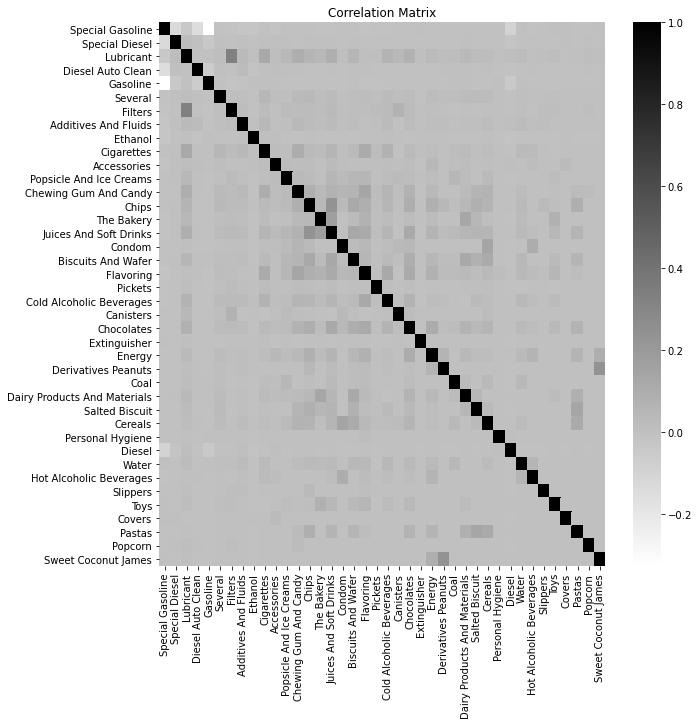

In [26]:
heatmap(output)